In [1]:
import cv2
import os 
import random
import numpy as np
from matplotlib import pyplot as plt


In [2]:
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense ,Input, Flatten , Layer
from tensorflow.keras.models import Model
import tensorflow as tf

In [2]:
# # Increasing Folder for This Project 
# try:
#  pos_path = os.path.join ("../Data","Positive")
#  neg_path = os.path.join ("../Data","Negative")
#  anc_path = os.path.join ("../Data","Anchor")

#  os.makedirs(pos_path)
#  os.makedirs(neg_path)
#  os.makedirs(anc_path)
# except:
#  print("Already Exist")


import torch

import ultralytics
 

In [6]:
# uncompressing the data

! tar -xf lfw.tgz 

tar: Error opening archive: Failed to open 'lfw.tgz'


In [3]:
import uuid

In [4]:
# cap = cv2.VideoCapture(r"F:\DATA Collections\22.mp4")
# number = 1
# Pos = 1
# while cap.isOpened():
#     try:
#         ret, frame = cap.read()
#         frame = cv2.resize(frame,(480,550))
#     # faces = face_classifier.detectMultiScale(frame)
#     # Cut down frame to 250x250px
#         # frame = frame[0:450,40:550, :]
#     except:
#         print("Video Done")
#         # cap.release()
# # Close the image show frame
#         # cv2.destroyAllWindows()
#         break

#     # for (x, y, w, h) in faces:
#     #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
#     # Collect anchors 
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         # Create the unique file path 
#         imgname = os.path.join("../Data/Anchor", f'{Anchor}.jpg')
#         Anchor = Anchor +1
#         # Write out anchor image
#         cv2.imwrite(imgname, frame)
#         print("Anchor " , number)
#         number = number + 1 
        
       
    
#     # Collect positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         # Create the unique file path 
#         imgname = os.path.join("../Data/Positive", f'{Positive}.jpg')
#         Positive = Positive +  1
#         # Write out positive image
#         cv2.imwrite(imgname, frame)
#         print("Postive ", Pos)
#         Pos = Pos + 1 
    
#     # Show image back to screen
#     cv2.imshow('Image Collection', frame)
    
#     # Breaking gracefully
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
        
# # Release the webcam
# cap.release()
# # Close the image show frame
# cv2.destroyAllWindows()




In [465]:
anchorpath = "../Data/Anchor"
Positive_path = "../Data/Positive"
Negative_path = "../Data/Negative"

In [466]:
anchor_files = sorted([os.path.join(anchorpath, f) for f in os.listdir(anchorpath) if f.endswith('.jpg')])
positive_files = sorted([os.path.join(Positive_path, f) for f in os.listdir(Positive_path) if f.endswith('.jpg')])
negative_files = sorted([os.path.join(Negative_path, f) for f in os.listdir(Negative_path) if f.endswith('.jpg')])

In [467]:
anchor = tf.data.Dataset.from_tensor_slices(anchor_files).take(536)
positive  = tf.data.Dataset.from_tensor_slices(positive_files).take(536)
negative  = tf.data.Dataset.from_tensor_slices(negative_files).take(536)


In [468]:
test = anchor.as_numpy_iterator()
test1 = positive.as_numpy_iterator()
test2 = negative.as_numpy_iterator()



In [469]:
print(test.next())
print(test1.next())
print(test2.next())


b'../Data/Anchor\\0.jpg'
b'../Data/Positive\\0.jpg'
b'../Data/Negative\\AJ_Cook_0001.jpg'


In [470]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img

In [471]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [339]:
sample = data.as_numpy_iterator()

In [340]:
first = sample.next()

In [472]:
def preprocess_twin(img_path , Validation_path , lable):
    return (preprocess(img_path),preprocess(Validation_path),lable)

In [473]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [474]:
round(len(data)*0.10)

107

In [475]:
# Training Data

train_data = data.take(round(len(data)*0.90))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing Data 

test_data = data.skip(round(len(data)*0.90))
test_data = test_data.take(round(len(data)*0.10))
test_data =  test_data.batch(16)
test_data = test_data.prefetch(8)


In [423]:
sample = data.as_numpy_iterator()

In [432]:
test_img = sample.next()

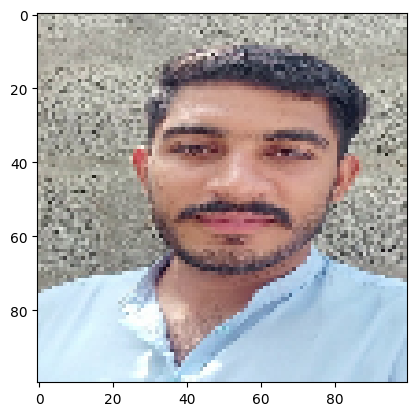

In [433]:
plt.imshow(test_img[0])

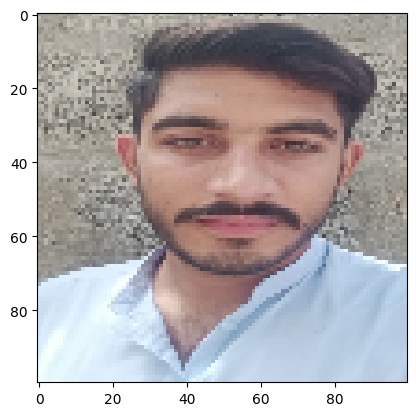

In [434]:
plt.imshow(test_img[1])

In [435]:
test_img[2]

1.0

In [476]:
# Build the Model Architecture 


def embedding():
    input = Input(shape=(100,100,3),name="Input_layer")

    # first layer 

    x = Conv2D(64 , (10,10),activation="relu",name="C1")(input)
    x = MaxPooling2D(64 , (2,2),padding="same",name = "M1")(x)

    # 2nd Layer 

    x = Conv2D(128,(7,7),activation="relu",name ='C2')(x)
    x = MaxPooling2D(64 , (2,2),padding="same",name = "M2")(x)

    # 3rd layer 

    x = Conv2D(128,(4,4),activation="relu",name ='C3')(x)
    x = MaxPooling2D(64 , (2,2),padding="same",name = "M3")(x)

    # final Layer 
    x = Conv2D(256,(4,4),activation="relu",name ='C4')(x)
    x = Flatten()(x)
    output = Dense(4096,activation="sigmoid")(x)

    return Model(inputs = input , outputs = output , name = "Embedding_model")





In [477]:
embedding = embedding()
embedding.summary()

Model: "Embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C1 (Conv2D)                     │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ M1 (MaxPooling2D)               │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C2 (Conv2D)                     │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ M2 (MaxPooling2D)               │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ M3 (MaxPooling2D)               │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C4 (Conv2D)                     │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [478]:
class L1Dist(Layer):

    def __init__(self , **kwargs):
        super().__init__(**kwargs)

    def call (self , input_embedding , validation_embedding):
        return tf.math.abs (input_embedding - validation_embedding)
    

In [479]:
def make_siamese_model():
    input_image = Input(name ="Input_img ", shape=(100,100,3))
    validation_image = Input(name="Validation_image ", shape=(100,100,3))
    siamese_layer = L1Dist()
    siamese_layer.__name = "Distance"
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    classifer = Dense(1 , activation="sigmoid")(distances)

    return Model(inputs=[input_image , validation_image],outputs = classifer , name="siamese_network")

In [484]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding_model     │ (None, 4096)      │ 38,960,448 │ Input_img [0][0], │
│ (Functional)        │                   │            │ Validation_image  │
│                     │                   │            │ [0][0]            │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ Embedding_model[… │
│                     │                   │            │ Embedding_model[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [490]:
# loss Function  and optimizer for our model 

binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(0.0001)

In [491]:
# Checkpoint

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [492]:
def calculate_accuracy(y_true, y_pred):
    y_pred = tf.round(tf.sigmoid(y_pred))
    correct_predictions = tf.cast(tf.equal(y_true, y_pred), tf.float32)
    accuracy = tf.reduce_mean(correct_predictions)
    return accuracy

In [493]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        # Calculate accuracy
        accuracy = calculate_accuracy(y, yhat)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Apply gradients
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss, accuracy

In [494]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Initialize total loss and accuracy
        total_loss = 0
        total_accuracy = 0
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step
            loss, accuracy = train_step(batch)
            total_loss += loss
            total_accuracy += accuracy
            progbar.update(idx+1)
        
        # Average loss and accuracy for this epoch
        avg_loss = total_loss / len(data)
        avg_accuracy = total_accuracy / len(data)
        
        print(f'Epoch {epoch}: Loss = {avg_loss:.4f}, Accuracy = {avg_accuracy:.4f}')
        
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [495]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
Epoch 1: Loss = 0.3282, Accuracy = 0.4938

 Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step
Epoch 2: Loss = 0.2108, Accuracy = 0.5040

 Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step
Epoch 3: Loss = 0.1867, Accuracy = 0.5004

 Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
Epoch 4: Loss = 0.1525, Accuracy = 0.4984

 Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step
Epoch 5: Loss = 0.1388, Accuracy = 0.4988

 Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step
Epoch 6: Loss = 0.0617, Accuracy = 0.5101

 Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step
Epoch 7: Loss = 0.1018, Accuracy = 0.4975

 Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step
Epoch 8: Loss = 0.0682, Accuracy = 0.5107

 Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step
Epoch 9: Loss = 0.0703, Accuracy = 0.5181

 Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step
Epoch 10: Loss = 0.0360, Accuracy = 0.5055

 Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/s

In [496]:
siamese_model.save("siamese_model.h5")

In [499]:
# Save the model using the native Keras format
siamese_model.save('siamese_model.keras')


In [501]:
from tensorflow.keras.metrics import Precision , Recall

In [679]:
test_input , test_val ,test_y = test_data.as_numpy_iterator().next()

In [680]:
test_y

array([0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

In [681]:
y_hat = siamese_model.predict([test_input,test_val])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


In [682]:
pre = [1 if prec > 0.5 else 0 for prec in y_hat]
pre

[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

In [683]:
# Recall and precision

m= Recall()
m.update_state(test_y,y_hat)
print("Recall ",m.result().numpy())
m= Precision()
m.update_state(test_y,y_hat)
print("Precision ",m.result().numpy())

Recall  1.0
Precision  1.0


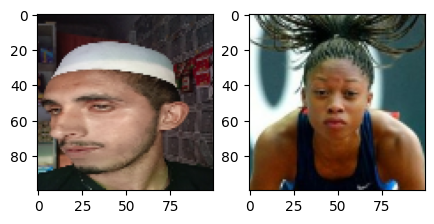

Prediction   0  Actual Value  0.0


In [696]:
# visualize the Result 
value = 15
plt.figure(figsize=(5,8))
plt.subplot(1,2,1)
plt.imshow(test_input[value])
plt.subplot(1,2,2)
plt.imshow(test_val[value])
plt.show()
print("Prediction  ",pre[value], " Actual Value ", test_y[value])